# Understanding Female Infertility Through Data: Risk Profiles and Condition Burdens
**[By: Nisha Kaushal, Data Scientist](https://www.linkedin.com/in/nisha-kaushal-748280175/)**

Infertility affects millions of individuals worldwide, yet its causes and contributing factors remain complex and multifaceted. In this project, I explore a binary clinical dataset focused on female fertility risk factors. Using machine learning and data analysis techniques, I aim to uncover patterns in how different conditions interact to influence infertility outcomes.

This report focuses on two key questions:

1. Can we identify **subtypes of infertility** based on common condition profiles? Using unsupervised clustering, I examine whether certain combinations of factors group together, potentially indicating distinct risk phenotypes.

2. Does the **number** of fertility-related conditions a patient has matter more than **which** specific conditions they have? I compare predictive models that use full condition details against those that rely solely on the overall burden (total number) of conditions to determine which approach offers stronger predictive power.

By combining these perspectives, this analysis aims to contribute to a more nuanced understanding of infertility risk and potential areas for personalized healthcare insights.

### Data Reading
& checking for null values!

In [1]:
pip install kmodes

Note: you may need to restart the kernel to use updated packages.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
#from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/female-infertility/Female Infertility Code.ipynb
/kaggle/input/female-infertility/Female infertility.csv


In [3]:
file_path = '/kaggle/input/female-infertility/Female infertility.csv'
df = pd.read_csv(file_path)
df.head()

,Patient ID,Age,Ovulation Disorders,Blocked Fallopian Tubes,Endometriosis,Uterine Abnormalities,Pelvic Inflammatory Disease,Hormonal Imbalances,Premature Ovarian Insufficiency,Autoimmune Disorders,Previous Reproductive Surgeries,Unexplained Infertility,Infertility Prediction
0,1,32,1,0,1,0,0,1,0,0,0,1,1
1,2,28,0,1,0,1,0,1,0,0,0,0,0
2,3,35,1,0,1,0,1,1,0,1,1,0,1
3,4,30,0,1,0,1,0,0,1,0,1,0,1
4,5,33,1,0,0,0,0,1,1,0,0,1,1


In [4]:
df.columns

Index(['Patient ID', 'Age', 'Ovulation Disorders', 'Blocked Fallopian Tubes',
       'Endometriosis', 'Uterine Abnormalities', 'Pelvic Inflammatory Disease',
       'Hormonal Imbalances', 'Premature Ovarian Insufficiency',
       'Autoimmune Disorders', 'Previous Reproductive Surgeries',
       'Unexplained Infertility', 'Infertility Prediction'],
      dtype='object')

In [5]:
print(f'There are {str(len(df))} patients in the dataset')

There are 705 patients in the dataset


In [6]:
df.dtypes

Patient ID                         int64
Age                                int64
Ovulation Disorders                int64
Blocked Fallopian Tubes            int64
Endometriosis                      int64
Uterine Abnormalities              int64
Pelvic Inflammatory Disease        int64
Hormonal Imbalances                int64
Premature Ovarian Insufficiency    int64
Autoimmune Disorders               int64
Previous Reproductive Surgeries    int64
Unexplained Infertility            int64
Infertility Prediction             int64
dtype: object

In [7]:
#check for any null values 
df.isnull().sum()

Patient ID                         0
Age                                0
Ovulation Disorders                0
Blocked Fallopian Tubes            0
Endometriosis                      0
Uterine Abnormalities              0
Pelvic Inflammatory Disease        0
Hormonal Imbalances                0
Premature Ovarian Insufficiency    0
Autoimmune Disorders               0
Previous Reproductive Surgeries    0
Unexplained Infertility            0
Infertility Prediction             0
dtype: int64

## K-Prototypes 
Because the data consists of both binary (categorical) data and continuous data, I am choosing to use K-prototypes as the clustering method. 

In [8]:
## Create copy of df --> so we don't have to worry about losing any columns in original df for later use
df1 = df.copy()
df1.drop(['Patient ID','Infertility Prediction'], axis = 1, inplace = True) #drop unnecessary columns for this task

# Split continuous and categorical/binary columns (technically this part isn't necessary since the features are already numerical)
binary_cols = [col for col in df1.columns if col != 'Age']
continuous_columns = ['Age']

#Get list of columns that are categorical 
cat_col_idx = [df1.columns.get_loc(col) for col in binary_cols]


# Convert categorical data to proper type (don't need this in this case since binary data is already int type)
#df1[categorical_columns] = df[categorical_columns].astype(int)

print(len(df1.columns))
print(len(cat_col_idx))
print(df1.columns[cat_col_idx]) #making sure we have only the binary data

11
10
Index(['Ovulation Disorders', 'Blocked Fallopian Tubes', 'Endometriosis',
       'Uterine Abnormalities', 'Pelvic Inflammatory Disease',
       'Hormonal Imbalances', 'Premature Ovarian Insufficiency',
       'Autoimmune Disorders', 'Previous Reproductive Surgeries',
       'Unexplained Infertility'],
      dtype='object')


### Elbow Method 
In order to find the optimal amount of clusters for K-Prototype, I will conduct the Elbow Method. I.e: 
1. Set a K range of cluster amounts
2. For each cluster number, conduct K-Prototyping and append the cost (the dissimilarity between the categorical object and the respective mode/centroid) to a list
3. Plot the costs against the number of clusters
4. Find which cluster amount (k) that forms the "elbow", or bend 

/tmp/ipykernel_13/4040078032.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, costs, 'bo-', color = 'indianred')


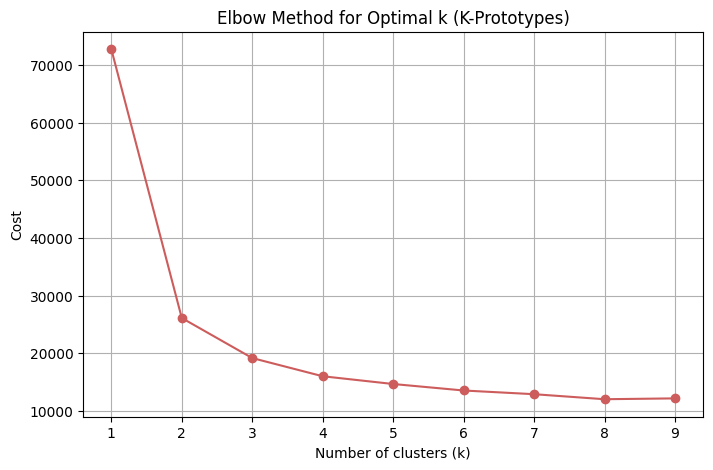

In [9]:
costs = []
K = range(1, 10)

for k in K:
    kproto = KPrototypes(n_clusters=k, init='Cao', n_init=3, verbose=0, random_state = 42)
    kproto.fit_predict(df1, categorical=cat_col_idx)
    costs.append(kproto.cost_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, costs, 'bo-', color = 'indianred')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k (K-Prototypes)')
plt.grid(True)
plt.show()

Based on the elbow method, 2 clusters would be ideal

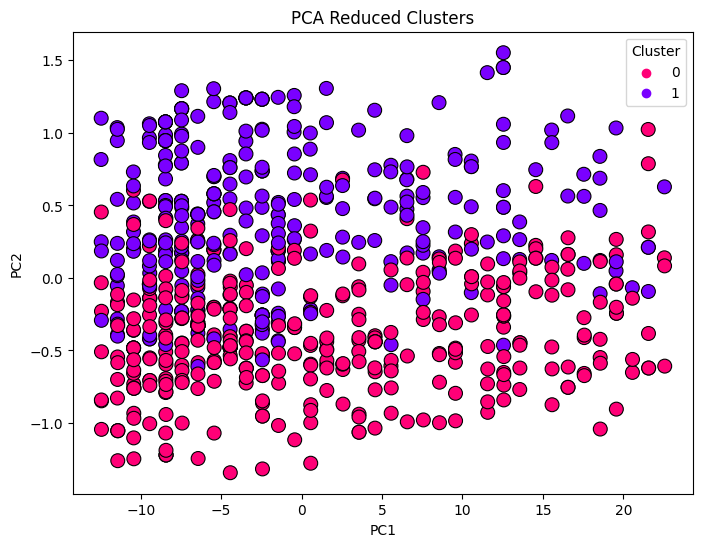

In [10]:
# Apply K-prototype clustering
kproto = KPrototypes(n_clusters=2, init='Cao', n_init=10, random_state = 42) #verbose=2 ##use verbose for debugging
clusters = kproto.fit_predict(df1, categorical=[0,1])

# Add cluster labels to df1
df1['Cluster'] = clusters

# Reduce data to 2D for visualization with PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df1[binary_cols + continuous_columns]) #the input does not include the Cluster column added to df1

# Create a DataFrame with reduced data and cluster labels
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['Cluster'] = df1['Cluster']

palette = {0: '#FF0077', 1: '#7a00ff'}  # deep pink and royal purple

# Plot the 2D clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=reduced_df, palette = palette, s = 100, marker = 'o', edgecolor = 'k') # s=100, edgecolor='k', marker='o')
plt.title('PCA Reduced Clusters')
plt.show()

In [11]:
#Check cluster composition (don't check the Age, since we know everyone has an age)
cluster_composition = df1[[col for col in df1.columns if col != 'Age']].groupby('Cluster').mean(numeric_only=True)

# Transpose for easier reading
composition_transposed = cluster_composition.T

# Print feature makeup per cluster
for feature in composition_transposed.index:
    print(f"\nFeature: {feature}")
    for cluster_id, proportion in enumerate(composition_transposed.loc[feature]):
        percentage = round(proportion * 100, 1)
        print(f"  Cluster {cluster_id}: {percentage}% have this feature")


Feature: Ovulation Disorders
  Cluster 0: 76.1% have this feature
  Cluster 1: 52.1% have this feature

Feature: Blocked Fallopian Tubes
  Cluster 0: 65.1% have this feature
  Cluster 1: 58.1% have this feature

Feature: Endometriosis
  Cluster 0: 61.7% have this feature
  Cluster 1: 56.9% have this feature

Feature: Uterine Abnormalities
  Cluster 0: 67.0% have this feature
  Cluster 1: 51.2% have this feature

Feature: Pelvic Inflammatory Disease
  Cluster 0: 68.6% have this feature
  Cluster 1: 64.2% have this feature

Feature: Hormonal Imbalances
  Cluster 0: 80.2% have this feature
  Cluster 1: 63.0% have this feature

Feature: Premature Ovarian Insufficiency
  Cluster 0: 70.8% have this feature
  Cluster 1: 56.6% have this feature

Feature: Autoimmune Disorders
  Cluster 0: 72.4% have this feature
  Cluster 1: 42.2% have this feature

Feature: Previous Reproductive Surgeries
  Cluster 0: 57.6% have this feature
  Cluster 1: 68.4% have this feature

Feature: Unexplained Infertili

In [12]:
#avg age per cluster
avg_age_per_cluster = df1.groupby('Cluster')['Age'].mean()

print("Average Age per Cluster:")
for cluster_id, avg_age in avg_age_per_cluster.items():
    print(f"  Cluster {cluster_id}: {avg_age:.1f} years")

Average Age per Cluster:
  Cluster 0: 38.6 years
  Cluster 1: 36.1 years


### Clustering Analysis: Can We Identify Subtypes of Infertility Based on Common Condition  
Using K-Prototype Clustering on the dataset containing one continuous variable (Age) and several binary (categorical) variables representing common infertility-related conditions, **two** meaningful clusters have been identified. These clusters reflect distinct risk phenotypes with different patterns of comorbid conditions and age profiles.

#### Cluster 0 
The first cluster identified (**Cluster 0**) represents a phenotype characterized by ***identifiable and potentially addressable causes of infertility***. Individuals in this cluster had a slightly **younger average age of 36.1 years**, and *only* **0.3% had unexplained infertility**. This group also showed a higher incidence of **previous reproductive surgeries** (68.4%). This possibly indicates a history of clearly diagnosed structural or mechanical reproductive issues. Additionally, they had generally lower rates of systemic conditions compared to cluster 1. This suggests patients may benefit from individualized, targeted treatment plans based on clearer diagnostic pathways.

#### Cluster 1
The second cluster identified (**Cluster 1**) represents a phenotype characterized by ***complex and multifactorial infertility***, with a strong presence of unexplained cases. Individuals in this cluster had a slightly **older age average of 38.6 years**, and a striking **98.4% had unexplained infertility**. They also exhibited high rates of systemic and overlapping conditions, including **Hormonal Imbalances** (80.2%), **Autoimmune Disorders** (72.4%), **Premature Ovarian Insufficiency** (70.8%), and **Uterine Abnormalities** (67.0%). These findings suggest that Cluster 0 individuals may face more challenging fertility journeys due to the interaction of multiple underlying biological factors, many of which may not present with clear diagnostic markers early on.





## Does the Number of Conditions Matter More Than Which Ones? 
In this section, I will look at if the overall number of conditions  


In [13]:
df2 = df.copy()

df2.drop(['Patient ID'], axis = 1, inplace = True)

df2.columns

Index(['Age', 'Ovulation Disorders', 'Blocked Fallopian Tubes',
       'Endometriosis', 'Uterine Abnormalities', 'Pelvic Inflammatory Disease',
       'Hormonal Imbalances', 'Premature Ovarian Insufficiency',
       'Autoimmune Disorders', 'Previous Reproductive Surgeries',
       'Unexplained Infertility', 'Infertility Prediction'],
      dtype='object')

In [14]:
df2 = df.copy()

df2.drop(['Patient ID'], axis = 1, inplace = True)

# Add 'condition burden' as a new feature
feature_cols = [col for col in df2.columns if col != 'Age']
df2['Condition Burden'] = df2[[f for f in feature_cols if f != 'Infertility prediction']].sum(axis=1)

# Comparison: model using burden vs. full features
X_full = df2[[f for f in feature_cols if f != 'Infertility prediction']]
X_burden = df2[['Condition Burden']]
y = df2['Infertility Prediction']

Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, y, test_size=0.2, random_state=42)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_burden, y, test_size=0.2, random_state=42)

# Train full model
clf_full = RandomForestClassifier(n_estimators=50,# Try smaller trees if overfitting occurs
    max_depth=4,# Limit tree depth
    min_samples_leaf=4,# Avoid overly specific splits
    random_state=42)
clf_full.fit(Xf_train, yf_train)
full_preds = clf_full.predict(Xf_test)
print("Full Model AUC:", roc_auc_score(yf_test, clf_full.predict_proba(Xf_test)[:, 1]))

# Train burden-only model
clf_burden = RandomForestClassifier(n_estimators = 50, 
                                    max_depth = 4,
                                    min_samples_leaf = 4, 
                                    random_state=42)
clf_burden.fit(Xb_train, yb_train)
burden_preds = clf_burden.predict(Xb_test)
print("Burden Model AUC:", roc_auc_score(yb_test, clf_burden.predict_proba(Xb_test)[:, 1]))

# Compare
print("\nClassification Report (Burden Model):")
print(classification_report(yb_test, burden_preds))

print("\nClassification Report (Full Feature Model):")
print(classification_report(yf_test, full_preds))


Full Model AUC: 1.0
Burden Model AUC: 0.9293411330049262

Classification Report (Burden Model):
              precision    recall  f1-score   support

           0       1.00      0.52      0.68        29
           1       0.89      1.00      0.94       112

    accuracy                           0.90       141
   macro avg       0.94      0.76      0.81       141
weighted avg       0.91      0.90      0.89       141


Classification Report (Full Feature Model):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00       112

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



#### Problem-Solving
It looks like there may be some overfitting when it comes to the full feature model. To check, I will first see if there is any data leakage through one or more features being directly correlated to Infertility Prediction

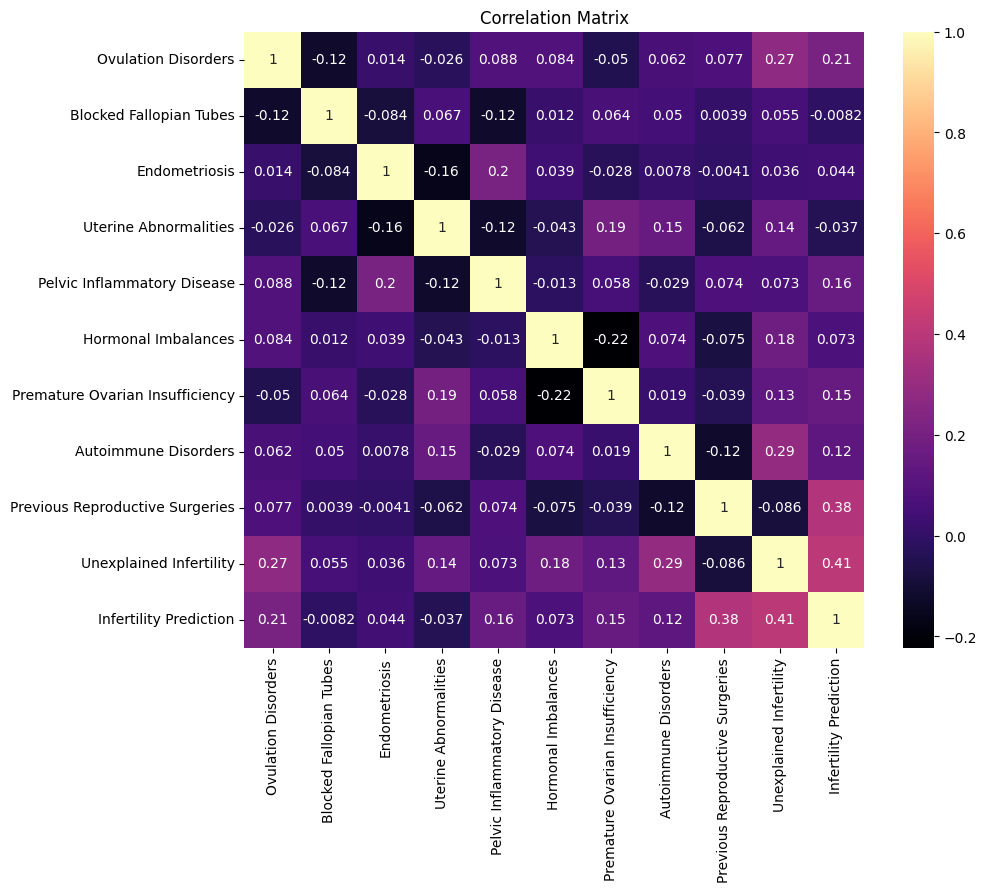

In [15]:
corr = X_full.copy()
corr['Infertility Prediction'] = y
plt.figure(figsize=(10,8))
sns.heatmap(corr.corr(), annot=True, cmap='magma')
plt.title("Correlation Matrix")
plt.show()


It looks like there is no strong correlation between any of the features and Infertility Prediction, so correlations may not be the reason for the overfitting.

Instead of Random Forest, I will try Support Vector Machine instead, since it is supposed to work well with smaller datasets

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

# Initialize and train the SVM model (start with linear kernel)
svm_model = SVC(kernel='linear', C=1.0, class_weight = 'balanced', random_state=42)
svm_model.fit(X_train, y_train)

# Predictions
y_pred = svm_model.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Optional: Cross-validation
cv_scores = cross_val_score(svm_model, X_full, y, cv=5)
print("Cross-validated accuracy scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00       112

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141

Confusion Matrix:
 [[ 29   0]
 [  0 112]]
Cross-validated accuracy scores: [1. 1. 1. 1. 1.]
Mean CV accuracy: 1.0


It looks like even with SVM, there is overfitting. 

One thing I did not check is if there were any duplicate rows in the data

In [17]:
print(f"The original data has {str(df.duplicated().sum())} duplicates")


The original data has 0 duplicates


Now let me check what happens when I drop the Patient ID (like in df2):


In [18]:
print(f"The data without the patient IDs has {str(df2.duplicated().sum())} duplicates")

The data without the patient IDs has 118 duplicates


This could be it! It looks like several patients have similar profiles, causing duplicates when dropping the Patient ID feature. I will try running the code for Random Forest Again, this time dropping the duplicate rows.

In [19]:
## Random Forest, dropping duplicates
df3 = df.copy()

df3.drop(['Patient ID'], axis = 1, inplace = True)
df3.drop_duplicates(inplace = True) #dropping the duplicates

# Add 'condition burden' as a new feature
feature_cols = [col for col in df3.columns if col != 'Age']
df3['Condition Burden'] = df3[[f for f in feature_cols if f != 'Infertility prediction']].sum(axis=1)

# Comparison: model using burden vs. full features
X_full = df3[[f for f in feature_cols if f != 'Infertility prediction']]
X_burden = df3[['Condition Burden']]
y = df3['Infertility Prediction']

Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, y, test_size=0.2, random_state=42)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_burden, y, test_size=0.2, random_state=42)

# Train full model
clf_full = RandomForestClassifier(n_estimators=50,# Try smaller trees if overfitting occurs
    max_depth=4,# Limit tree depth
    min_samples_leaf=4,# Avoid overly specific splits
    random_state=42)
clf_full.fit(Xf_train, yf_train)
full_preds = clf_full.predict(Xf_test)
print("Full Model AUC:", roc_auc_score(yf_test, clf_full.predict_proba(Xf_test)[:, 1]))

# Train burden-only model
clf_burden = RandomForestClassifier(n_estimators = 50, 
                                    max_depth = 4,
                                    min_samples_leaf = 4, 
                                    random_state=42)
clf_burden.fit(Xb_train, yb_train)
burden_preds = clf_burden.predict(Xb_test)
print("Burden Model AUC:", roc_auc_score(yb_test, clf_burden.predict_proba(Xb_test)[:, 1]))

# Compare
print("\nClassification Report (Burden Model):")
print(classification_report(yb_test, burden_preds))

print("\nClassification Report (Full Feature Model):")
print(classification_report(yf_test, full_preds))


Full Model AUC: 1.0
Burden Model AUC: 0.9264214046822742

Classification Report (Burden Model):
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        26
           1       0.92      0.92      0.92        92

    accuracy                           0.88       118
   macro avg       0.83      0.83      0.83       118
weighted avg       0.88      0.88      0.88       118


Classification Report (Full Feature Model):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        92

    accuracy                           1.00       118
   macro avg       1.00      1.00      1.00       118
weighted avg       1.00      1.00      1.00       118



## Models, with dropped duplicates (Random Forest) with PCA


Still getting perfect classification, now I will try dimensionality reduction (PCA) so that the model will not be able to memorize exact profiles:

In [20]:
df2 = df.copy()

df2.drop(['Patient ID'], axis = 1, inplace = True)
df2.drop_duplicates(inplace = True)

# Add 'condition burden' as a new feature
feature_cols = [col for col in df2.columns if col != 'Age']
df2['Condition Burden'] = df2[[feature for feature in feature_cols if feature != 'Infertility Prediction']].sum(axis=1)

# Comparison: model using burden vs. full features
X_full = df2[[feature for feature in feature_cols if feature != 'Infertility Prediction']]

##apply pca to X_full, using 5 components

### 1. Scale Data
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)
### 2. Apply PCA
pca = PCA(n_components=5, random_state=42)
X_full_pca = pca.fit_transform(X_full_scaled)

#Burden doesn't need pca because it's only 1 feature
X_burden = df2[['Condition Burden']]
y = df2['Infertility Prediction']

### train/test split, using X_full_pca instead of X_full
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full_pca, y, test_size=0.2, random_state=42)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_burden, y, test_size=0.2, random_state=42)

# Train full model
clf_full = RandomForestClassifier(n_estimators=50,# Try smaller trees if overfitting occurs
    max_depth=4,# Limit tree depth
    min_samples_leaf=4,# Avoid overly specific splits
    random_state=42)
clf_full.fit(Xf_train, yf_train)
full_preds = clf_full.predict(Xf_test)
print("Full Model AUC:", roc_auc_score(yf_test, clf_full.predict_proba(Xf_test)[:, 1]))

# Train burden-only model
clf_burden = RandomForestClassifier(n_estimators = 50, 
                                    max_depth = 4,
                                    min_samples_leaf = 4, 
                                    random_state=42)
clf_burden.fit(Xb_train, yb_train)
burden_preds = clf_burden.predict(Xb_test)
print("Burden Model AUC:", roc_auc_score(yb_test, clf_burden.predict_proba(Xb_test)[:, 1]))

# Compare
print("\nClassification Report (Burden Model):")
print(classification_report(yb_test, burden_preds))

print("\nClassification Report (Full Feature Model):")
print(classification_report(yf_test, full_preds))


Full Model AUC: 0.8760451505016723
Burden Model AUC: 0.8329849498327759

Classification Report (Burden Model):
              precision    recall  f1-score   support

           0       0.80      0.15      0.26        26
           1       0.81      0.99      0.89        92

    accuracy                           0.81       118
   macro avg       0.80      0.57      0.57       118
weighted avg       0.80      0.81      0.75       118


Classification Report (Full Feature Model):
              precision    recall  f1-score   support

           0       0.73      0.42      0.54        26
           1       0.85      0.96      0.90        92

    accuracy                           0.84       118
   macro avg       0.79      0.69      0.72       118
weighted avg       0.83      0.84      0.82       118



#### Visualize the Classification Reports for Better Clarity

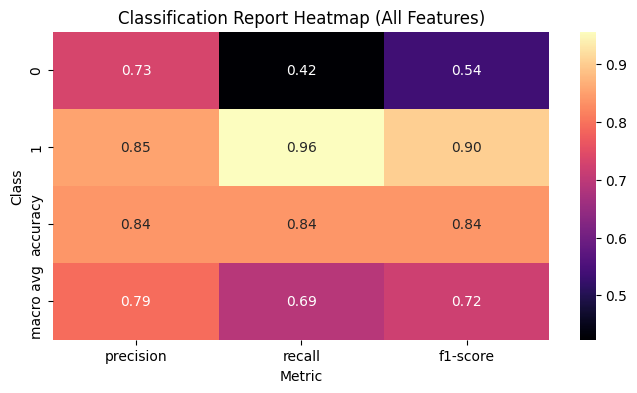

In [21]:
# Classification Report for All Features
# Get predictions (replace with your actual predictions and y_test)
y_true = yf_test  # or yb_test for burden
y_pred = full_preds  # or burden_preds

# Generate report
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().iloc[:-1, :-1]  # Remove accuracy row

# Plot
plt.figure(figsize=(8, 4))
sns.heatmap(report_df, annot=True, cmap='magma', fmt=".2f")
plt.title("Classification Report Heatmap (All Features)")
plt.ylabel("Class")
plt.xlabel("Metric")
plt.show()


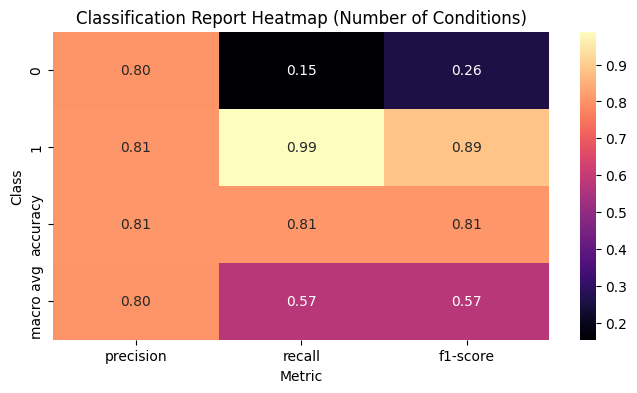

In [22]:
# Classification Report for All Features
# Get predictions 
yf_true = yb_test  # or yb_test for burden
yf_pred = burden_preds  # or burden_preds

# Generate report
report = classification_report(yf_true, yf_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().iloc[:-1, :-1]  # Remove accuracy row

# Plot
plt.figure(figsize=(8, 4))
sns.heatmap(report_df, annot=True, cmap='magma', fmt=".2f")
plt.title("Classification Report Heatmap (Number of Conditions)")
plt.ylabel("Class")
plt.xlabel("Metric")
plt.show()

Based on metrics, the full-feature model outperformed the burden load-only model. 

Because the full-feature model used PCA, I can further run more metrics, namely: <br> 
**Feautre Importance**: <br>
**Permutation Importance**

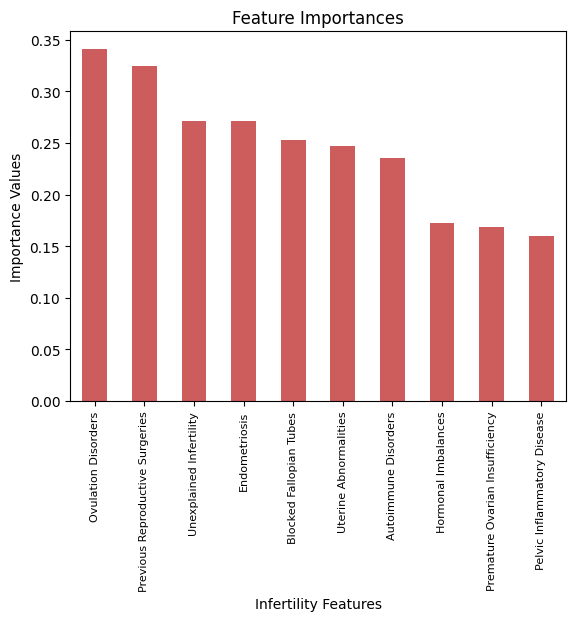

In [23]:
## Feature importance 
pc_importances = clf_full.feature_importances_

# Map back to original features
# Shape: (original_features, n_components)
loadings = pca.components_.T

# Weighted sum of absolute loadings by model's PC importance
original_feature_importance = np.dot(np.abs(loadings), pc_importances)

# Put into a readable format
feature_names = X_full.columns
feature_importance_df = pd.Series(original_feature_importance, index=feature_names)
feature_importance_df = feature_importance_df.sort_values(ascending=False)

# Display
#feature_importance_df

##Visualize 
feature_importance_df.plot(kind='bar', color = 'indianred')

# Customize the plot
plt.title('Feature Importances')
plt.xlabel('Infertility Features')
plt.ylabel('Importance Values')
plt.xticks(rotation= 90, fontsize = 8)

# Show the plot
plt.show()

**Interpretation**:
Based on the feature importances shown above, Ovarian Disorders and Previous Reproductive Sugeries contribute more indirectly to the model's predictive power via its influence on the principal components. Premature Ovarian Insufficiency and Pelvic Inflammatory Disease contribute the least. 

It is important to remember that these feature importances are *approximations* in the original feature space, reconstructed from the PCA components.

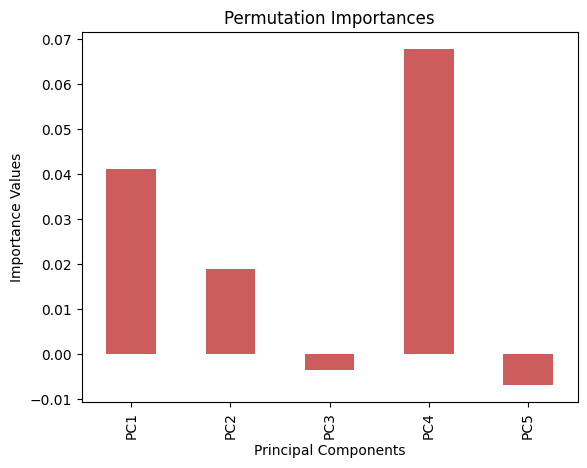

In [24]:
##Permutation Importance
perm_imp = permutation_importance(clf_full, Xf_test, yf_test, n_repeats=30)
perm_imp_df = pd.Series(perm_imp.importances_mean, index=[f'PC{i+1}' for i in range(pca.n_components_)])
#perm_imp_df #display 

##VIsualize 
perm_imp_df.plot(kind='bar', color = 'indianred')

# Customize the plot
plt.title('Permutation Importances')
plt.xlabel('Principal Components')
plt.ylabel('Importance Values')

# Show the plot
plt.show()



According to the permutation importance, principal component 4 is the most important for prediction, followed by PC1. 

I can now map PC4 back to its original features:

In [25]:
# Get original feature names
feature_names = X_full.columns 

# Get the PCA components
pca_components = pd.DataFrame(pca.components_, columns=feature_names, index=[f'PC{i+1}' for i in range(pca.n_components_)])

# Step 3: View top contributing features for most important PCs
# Look at PC4 (your most important)
pc4_loadings = pca_components.loc['PC4'].sort_values(key=np.abs, ascending=False)
pc1_loadings = pca_components.loc['PC1'].sort_values(key=np.abs, ascending=False)
print("Top features contributing to PC4:")
print(pc4_loadings.head(10))
print('\n')
print('Top features contributing to PC1:')
print(pc1_loadings.head(10))


Top features contributing to PC4:
Previous Reproductive Surgeries   -0.742634
Ovulation Disorders               -0.470578
Endometriosis                      0.337816
Autoimmune Disorders               0.257938
Blocked Fallopian Tubes           -0.148446
Hormonal Imbalances                0.105121
Unexplained Infertility           -0.097158
Uterine Abnormalities             -0.059174
Premature Ovarian Insufficiency   -0.018561
Pelvic Inflammatory Disease        0.005232
Name: PC4, dtype: float64


Top features contributing to PC1:
Unexplained Infertility           -0.594043
Autoimmune Disorders              -0.479046
Uterine Abnormalities             -0.425386
Ovulation Disorders               -0.281521
Premature Ovarian Insufficiency   -0.232662
Previous Reproductive Surgeries    0.188186
Hormonal Imbalances               -0.181902
Endometriosis                      0.168031
Pelvic Inflammatory Disease        0.071555
Blocked Fallopian Tubes           -0.037845
Name: PC1, dtype: float6

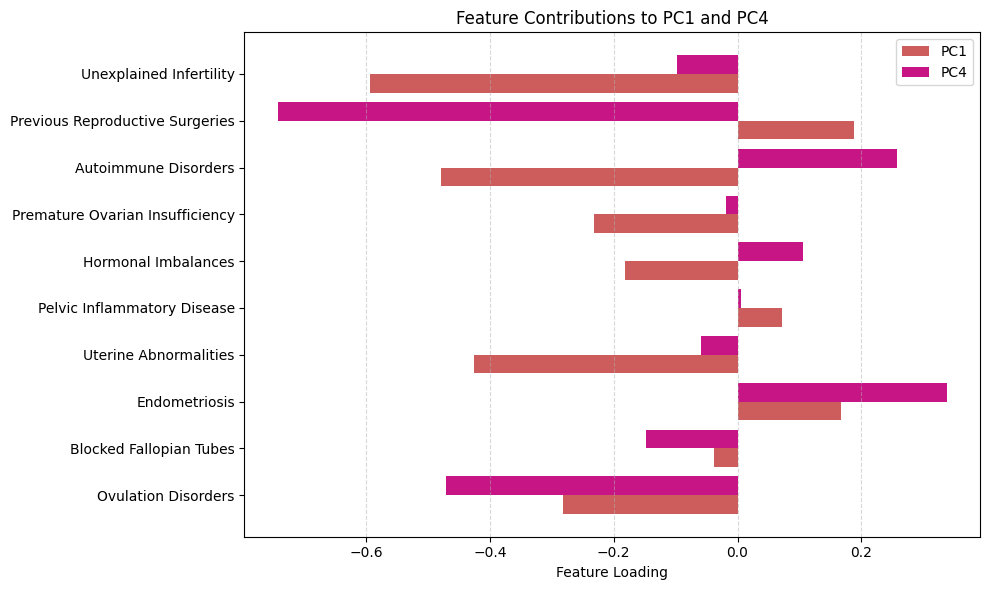

In [26]:
#Visualize for easier comparison: 
feature_names = X_full.columns  # these are your original feature names
components = pca.components_  # shape: (n_components, n_features)

# Create DataFrame of loadings
loadings_df = pd.DataFrame(components.T, index=feature_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
pc_subset = loadings_df[['PC1', 'PC4']]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width and position offsets
bar_width = 0.4
features = pc_subset.index
x = range(len(features))

# Plot PC1
ax.barh([i - bar_width/2 for i in x], pc_subset['PC1'], height=bar_width, color='indianred', label='PC1')

# Plot PC4
ax.barh([i + bar_width/2 for i in x], pc_subset['PC4'], height=bar_width, color='mediumvioletred', label='PC4')

# Formatting
ax.set_yticks(x)
ax.set_yticklabels(features)
ax.set_xlabel('Feature Loading')
ax.set_title('Feature Contributions to PC1 and PC4')
ax.legend()
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

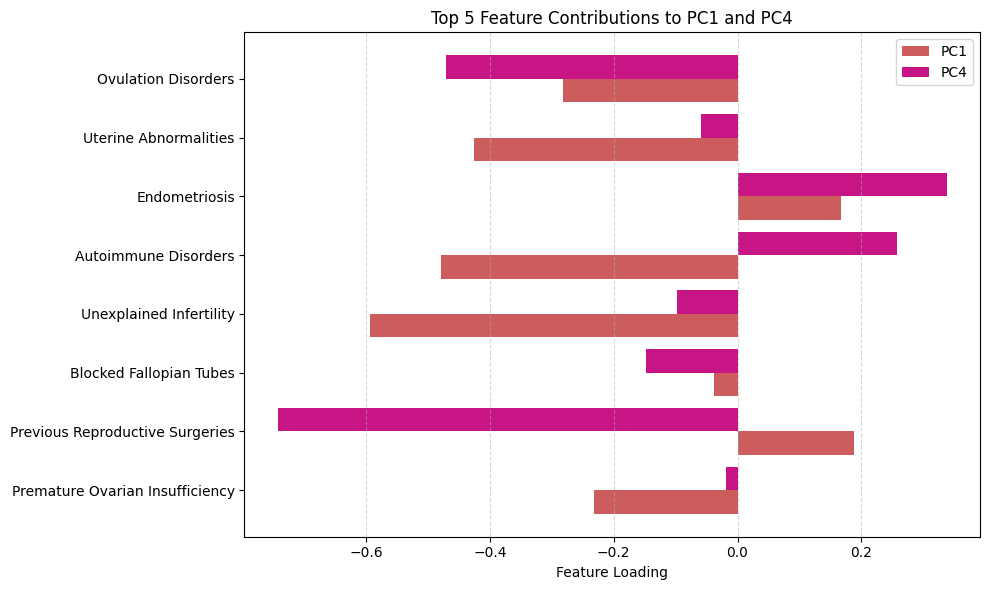

In [27]:
##Look at top 5
# Get top 5 contributors by absolute value for each PC
top_pc1 = loadings_df['PC1'].abs().nlargest(5).index
top_pc4 = loadings_df['PC4'].abs().nlargest(5).index

# Combine and drop duplicates to get full list of features to plot
top_features = list(set(top_pc1).union(set(top_pc4)))
pc_subset = loadings_df.loc[top_features, ['PC1', 'PC4']]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.4
x = range(len(pc_subset))

# Plot PC1
ax.barh([i - bar_width/2 for i in x], pc_subset['PC1'], height=bar_width, color='indianred', label='PC1')

# Plot PC4
ax.barh([i + bar_width/2 for i in x], pc_subset['PC4'], height=bar_width, color='mediumvioletred', label='PC4')

# Formatting
ax.set_yticks(x)
ax.set_yticklabels(pc_subset.index)
ax.set_xlabel('Feature Loading')
ax.set_title('Top 5 Feature Contributions to PC1 and PC4')
ax.legend()
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

### Analysis: Do Specific Conditions Matter More Than the Number of Conditions?
To assess whether infertility is better predicted by the specific conditions present or simply by the total number of conditions (“condition burden”), I compared two models: one trained on a single feature representing condition burden, and another trained on all individual condition features reduced using **Principal Component Analysis (PCA)**.

While both models performed well, the full-feature PCA model outperformed the burden-only model (AUC: 0.88 vs 0.83), suggesting that which conditions a patient has matters more than just how many.

Further, PCA revealed two key components— **PC1 and PC4** —as influential in predicting infertility. PC1 was primarily driven by high negative loadings from Unexplained Infertility, Autoimmune Disorders, and Premature Ovarian Insufficiency, suggesting it represents a **latent dimension of diagnostic complexity or systemic conditions**. In contrast, PC4 was shaped by a strong negative loading from Previous Reproductive Surgeries and positive contributions from Endometriosis and Autoimmune Disorders, indicating a component related to **surgical and inflammatory reproductive history**. These findings support that specific combinations of conditions, rather than condition count alone, carry significant predictive value.

Together, these findings indicate that specific condition patterns carry more predictive power, reinforcing the clinical relevance of individualized diagnosis over general burden assessment.


### Conclusion
Female infertility is a complex and multifaceted condition affecting millions of individuals globally. It is estimated that about 1 in 8 couples experience difficulty conceiving, and for many women, identifying the cause of infertility can be a prolonged and emotionally taxing process. Infertility can stem from structural, hormonal, immunological, or unexplained origins—often involving more than one contributing factor. This heterogeneity makes both diagnosis and treatment challenging, underscoring the need for better stratification of patients and more nuanced predictive tools.

This project explored two key questions in the context of female infertility: whether distinct subtypes of infertility can be identified through clustering analysis, and whether infertility outcomes are more influenced by the specific conditions a patient has or the overall number of co-occurring conditions.

Clustering analysis using K-Prototypes revealed two meaningful phenotypic subgroups. One group, characterized by clearly identifiable conditions such as previous reproductive surgeries and a lower incidence of unexplained infertility, may benefit from more targeted interventions. The other cluster, by contrast, was dominated by individuals with a high prevalence of systemic and overlapping conditions like hormonal imbalances, autoimmune disorders, and premature ovarian insufficiency—along with a near-universal rate of unexplained infertility. This group reflects a more elusive diagnostic profile, often seen in clinical settings, where patients face multifactorial barriers to conception that don’t always yield straightforward treatment paths.

In parallel, the comparative modeling analysis showed that condition specificity—rather than just the count of conditions—plays a greater role in predicting infertility. While both the burden-only model and the full-feature PCA model achieved high performance, the PCA model demonstrated superior predictive power. Importantly, the latent components revealed by PCA (specifically PC1 and PC4) pointed to distinct condition patterns that carried more clinical weight. PC1 appeared to reflect a systemic or diagnostic complexity axis, with strong contributions from unexplained infertility and autoimmune-related conditions. PC4, meanwhile, highlighted a different dimension rooted in reproductive history and inflammation, including endometriosis and prior surgeries.

Together, these findings suggest that infertility is not merely a matter of accumulating risk factors, but of the specific nature and interaction of those factors. By identifying subgroups with shared condition profiles and isolating condition clusters that drive predictive success, this study supports a move toward more individualized diagnostic frameworks in reproductive medicine. It highlights the value of combining unsupervised and supervised learning approaches to enhance both stratification and prediction in complex clinical phenomena like female infertility.

Ultimately, this work underscores the need for precision in reproductive health—not only in treatment, but in how we define and understand infertility itself.